In [81]:
#hide code
#from https://stackoverflow.com/a/28073228
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Abstract
put abstract here.

In [3]:
# Import used libraries.
import torch
import pandas as pd
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable
import subprocess
import time
import csv

from dataset import OdometryDataset
from dataset import ToTensor

from model import vel_regressor

In [4]:
load_model = True
save_model = False
train_model= False

In [14]:
#add path to folders to train on
folders=[]
for i in [13,15,16,17,1,2,3,5,6,8,9,10,11,12,18,19,20,21,22]:  
    path= '/advio-'+str(i).zfill(2)+'/'
    folders.append(path)
# folders.append("/aalto-cs/dataset-01/")
# folders.append("/aalto-cs/dataset-03/")
# folders.append("/aalto-cs/dataset-04/")
# folders.append("/aalto-cs/dataset-05/")
# folders.append("/kamppi/dataset-01/")
# folders.append("/kamppi/dataset-02/")
# folders.append("/kamppi/dataset-03/")
# folders.append("/kamppi/dataset-05/")
# folders.append("/kamppi/dataset-06/")
# folders.append("/kamppi/dataset-08/")
# folders.append("/kamppi/dataset-09/")
# folders.append("/kamppi/dataset-10/")
# folders.append("/kamppi/dataset-11/")
# folders.append("/kamppi/dataset-12/")
# folders.append("/tuas/dataset-01/")
# folders.append("/tuas/dataset-02/")
# folders.append("/outdoor-cs/dataset-01/")
# folders.append("/outdoor-cs/dataset-02/")
# folders.append("/outdoor-hk/dataset-01/")
# folders.append("/static/dataset-01/")
# folders.append("/static/dataset-02/")
# folders.append("/static/dataset-03/")
# folders.append("/swing/dataset-01/")
print folders

['/advio-13/', '/advio-15/', '/advio-16/', '/advio-17/', '/advio-01/', '/advio-02/', '/advio-03/', '/advio-05/', '/advio-06/', '/advio-08/', '/advio-09/', '/advio-10/', '/advio-11/', '/advio-12/', '/advio-18/', '/advio-19/', '/advio-20/', '/advio-21/', '/advio-22/']


In [15]:
#manual labels for visualization (tied to the folder order created above.)

# standing=0
# walking =1
# staris=2
# escalators=3
# elevator=4
labs=[]
with open('labels.csv', 'rb') as csvfile:
     spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
     for row in spamreader:
        labs.append([int(row[0]),int(row[1]),int(row[2]),float(row[3]),])

## Labels

The labels are put there to visualize the results after prediction. And to see how the performance correlates to the motion modes. The labeling is done by hand  and it is not very accurate.

* standing=0
* walking =1
* staris=2
* escalators=3
* elevator=4

75


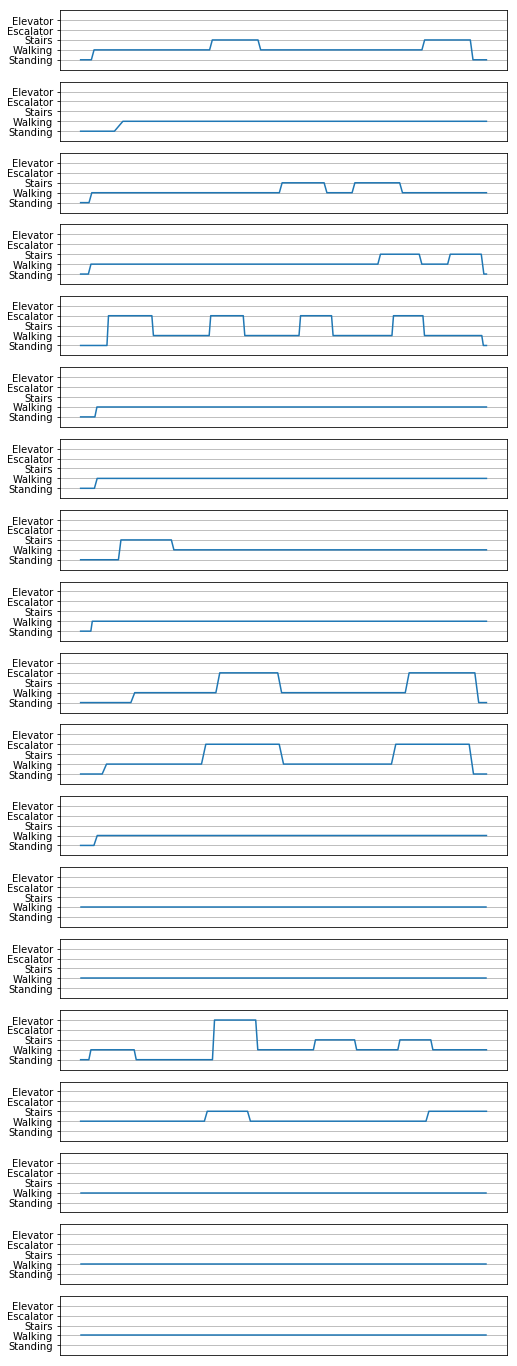

3561
3561
3571


In [16]:
#visualize labels in time vector.

#control variables, initialize arrays.
ind=0
acc_lab=0
acc_dat=0
data_labels=[]
plt.figure(figsize=(8, 30))
for idx, folder in enumerate(folders):
    #print(folder)
    
    data=OdometryDataset("../data",[folder],transform=ToTensor())
    stay=True
    while labs[ind][3]==-2:
        ind=ind+1           
    stay=True
    dat=[]   
    dat.append([-1,0])
    while stay:
        tim=labs[ind][3]
        tim=np.round(np.floor(tim)*60+(tim-np.floor(tim))*100)
        data_length=(2+(data[len(data)]['time'])-data[0]['time'])[0]        
        if labs[ind][3]==-1:            
            stay=False
            tim=10000
        lab=labs[ind][2]
        dat.append([tim,lab])
        ind=ind+1   
    
    #print(data_length)
    label=[]
    start=data[0]['time']
    for i in range(0,len(data)):
        t=data[i]['time']-start
        for j in range(0,len(dat)-1):
            if t<dat[j+1][0] and t>dat[j][0]:
                label.append(dat[j+1][1])
    #print(len(data))
    #print(len(label))
    acc_dat=acc_dat+len(data)
    acc_lab=acc_lab+len(label)
    plt.subplot(23,1,idx+1)
    plt.plot(label)
    plt.ylim(-1,5)
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    #frame1.axes.get_yaxis().set_visible(False)
    plt.yticks([0,1,2,3,4], ['Standing','Walking','Stairs','Escalator','Elevator'])
    plt.grid(b=True,axis='y')
    
    data_labels.append(label)
print(ind)

plt.show()
print(acc_dat)
print(acc_lab)
data=OdometryDataset("../data",folders,transform=ToTensor())
print(len(data))  

In [17]:
# Create dataset reader.
T=OdometryDataset("../data",folders,transform=ToTensor())
# Create Model.
model=vel_regressor(Nout=1,Nlinear=7440)
l=[]
val=[]

## Data

Visualize velocity vectors and speed value for the entire dataset. This is extracted using 1000 samples evenly distributed trough the data.

Note the uneven distribution of speeds for the first 800 samples, where standing still is underrepresented. For this the last sequences were created where the phone is just held  in the hand.

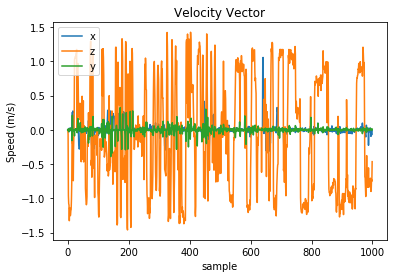

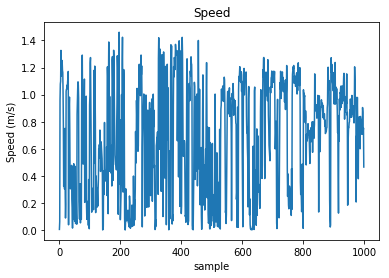

In [27]:
#print(np.shape(velo))
velo=[]
sp=[]
t=[]
#print(np.shape(velo))
index=(np.round(np.linspace(0,len(T),1000)))
for i in index:
    #print(i)
    data=T[int(i)]
    velo.append(data['gt'].numpy())
    sp.append((data['gt'].norm()))
    t.append(data['time'])
plt.figure()
plt.plot(velo)
plt.title('Velocity Vector')
plt.xlabel('sample')
plt.ylabel('Speed (m/s)')
plt.legend(['x','z','y'])
plt.figure()
plt.title('Speed')
plt.xlabel('sample')
plt.ylabel('Speed (m/s)')
plt.plot(sp)
plt.show()

In [19]:

#Configure data loaders and optimizer
learning_rate = 1e-6
loss_fn = torch.nn.MSELoss(size_average=False)
index=np.arange(len(T))
np.random.shuffle(index)
train=index[1:int(np.floor(len(T)/10*9))]
test=index[int(np.floor(len(T)/10*9)):-1]
#Split training and validation.
training_loader = DataLoader(T, batch_size=10,shuffle=False, num_workers=4,sampler=torch.utils.data.sampler.SubsetRandomSampler(list(train)))
validation_loader = DataLoader(T, batch_size=10,shuffle=False, num_workers=4,sampler=torch.utils.data.sampler.SubsetRandomSampler(list(test)))
#Create secondary loaders
single_train_Loader = DataLoader(T, batch_size=1,shuffle=False, num_workers=1,sampler=torch.utils.data.sampler.SubsetRandomSampler(list(train)))
single_validation_Loader = DataLoader(T, batch_size=1,shuffle=False, num_workers=1,sampler=torch.utils.data.sampler.SubsetRandomSampler(list(test)))
ordered_Loader = DataLoader(T, batch_size=1,shuffle=False, num_workers=1)
#define optimizer.
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

if train_model:

    # Epochs
    for t in range(100):
        ti = time.time()
        acc_loss=0;
        val_loss=0;
        # Train
        for i_batch, sample_batched in enumerate(training_loader):
            # Sample data.
            data=sample_batched
            # Forward pass.
            y_pred =model(Variable(data['imu'].float()))     
            # Sample corresponding ground truth.
            y=torch.norm(data['gt'],2,1).type(torch.FloatTensor)
            # Compute and print loss.
            loss = loss_fn(y_pred,Variable(y))
            # Save loss.
            acc_loss +=np.sum(loss.data[0])
            # Zero the gradients before running the backward pass.
            model.zero_grad()
            # Backward pass.
            loss.backward()
            # Take optimizer step.
            optimizer.step()
        # Validation
        for i_batch, sample_batched in enumerate(validation_loader):
            # Sample data.
            data=sample_batched
            # Forward pass.   
            y_pred =model(Variable(data['imu'].float()))    
            vec=data['gt']
            y=torch.norm(data['gt'],2,1).type(torch.FloatTensor)
            loss = loss_fn(y_pred,Variable(y))
            val_loss +=np.sum(loss.data[0])
        # Save loss and print status.
        l.append(acc_loss/(len(T)*9/10))
        val.append(val_loss/(len(T)/10))
        print(t)
        print(l[-1])
        print(val[-1])
        elapsed = time.time() - ti
        print(elapsed)
    # Plot loss
    plt.plot(np.log(np.array(l)),label = 'Training loss')
    plt.plot(np.log(np.array(val)),label = 'Validation loss')
    plt.show()

In [20]:
#load pretrained model.
if load_model:
    #model = torch.load('./full.pt')
    model= torch.load('./full.pt', map_location=lambda storage, loc: storage)
    

#save model
if save_model:
    torch.save(model,'./full.pt')

## Results

The network predicted speed is shown as well as the ground truth. Other interesting data is also shown.

(3571, 1)


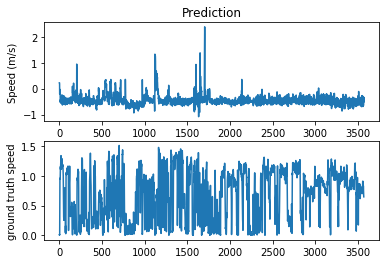

In [21]:
# Load corresponding prediction and ground truth
pred=[]
sp=[]
for i_batch, sample_batched in enumerate(ordered_Loader):
    data=sample_batched

    pred.append(model(Variable(data['imu'].float())).data[0].numpy())

    vec=data['gt']

    y=torch.norm(data['gt'],2,1).type(torch.FloatTensor)
    sp.append(y.type(torch.FloatTensor).numpy())
        
print(np.shape((np.asarray(sp))))
plt.subplot(211)
plt.plot(np.asarray(pred)[:,:])
plt.ylabel('Speed (m/s)')
plt.title('Prediction')
plt.subplot(212)
plt.plot(np.asarray(sp)[:,0])
plt.ylabel('ground truth speed')
plt.show()


pred=np.asarray(pred)
sp=np.asarray(sp)


In [11]:

plt.clf()
dat_lab=[]
for label in data_labels:
    dat_lab=dat_lab+label


fig = plt.figure(figsize=(6,6))
pred=[]
sp=[]
R=[]
for i_batch, sample_batched in enumerate(ordered_Loader):
    data=sample_batched
    pred.append(model(Variable(data['imu'].float())).data[0].numpy())
    vec=data['gt']
    #vertical=torch.norm(vec[:,[1]],2,1) 
    #vertical=vec[:,[1]]
    #horizontal=torch.norm(vec[:,[0,2]],2,1)  
    #y=torch.stack((vertical,horizontal),1)
    y=torch.norm(data['gt'],2,1).type(torch.FloatTensor)
    sp.append(y.type(torch.FloatTensor).numpy())
    R.append(np.array(data['range']))
    #print(R[-1])
print(len(dat_lab))
print(len(sp))
pred=np.asarray(pred)
sp=np.asarray(sp)    
stat=[]
stair=[]
walk=[]
esc=[]
ele=[]

Rstat=[]
Rstair=[]
Rwalk=[]
Resc=[]
Rele=[]

for i in range(0,len(dat_lab)):
    if dat_lab[i]==0:
        stat.append([sp[i,0],pred[i]])
        Rstat.append(R[i])
    elif dat_lab[i]==1:
        walk.append([sp[i,0],pred[i]])
        Rwalk.append(R[i])
    elif dat_lab[i]==2:
        stair.append([sp[i,0],pred[i]])
        Rstair.append(R[i])
    elif dat_lab[i]==3:
        esc.append([sp[i,0],pred[i]])
        Resc.append(R[i])
    else:
        ele.append([sp[i,0],pred[i]])
        Rele.append(R[i])




# with open('spread.csv', 'wb') as csvfile:
#     spamwriter = csv.writer(csvfile, delimiter=',',
#                             quotechar='|', quoting=csv.QUOTE_MINIMAL)
#     for  i  in range(0,len(dat_lab)):
#         spamwriter.writerow([pred[i],sp[i],dat_lab[i],R[i][0],R[i][1]])
        
        
        

print(len(dat_lab))
print(len(sp))


4421
4432
4421
4432


<Figure size 432x288 with 0 Axes>

<Figure size 432x432 with 0 Axes>

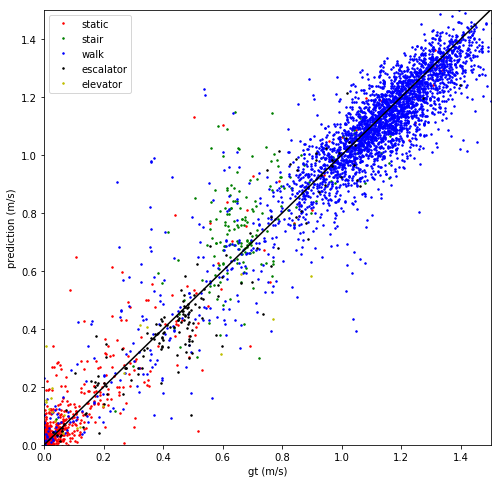

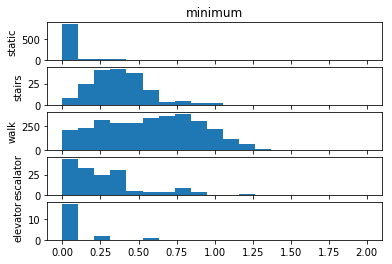

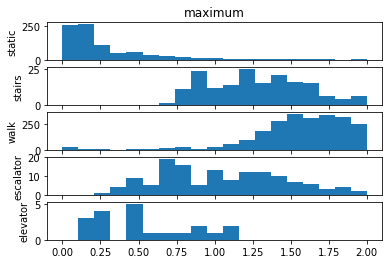

In [12]:
# Split data into labels and show spread
plt.clf()
msize=3
plt.figure(figsize=(8,8))

test=np.array(stat)
plt.plot(test[:,0],test[:,1],'r.',label='static',markersize=msize)
test=np.array(stair)
plt.plot(test[:,0],test[:,1],'g.',label='stair',markersize=msize)
test=np.array(walk)
plt.plot(test[:,0],test[:,1],'b.',label='walk',markersize=msize)
test=np.array(esc)
plt.plot(test[:,0],test[:,1],'k.',label='escalator',markersize=msize)
test=np.array(ele)
plt.plot(test[:,0],test[:,1],'y.',label='elevator',markersize=msize)

plt.plot([0,1.5],[0,1.5],'k')
plt.xlabel('gt (m/s)')
plt.ylabel('prediction (m/s)')

axes=plt.gca()

axes.set_xlim((0.0,1.5))
axes.set_ylim([0.0,1.5])
axes.legend()
#axes.grid(b=True, which='major', color='k', linestyle='--')
bins=np.linspace(0.0,2.0,20)
f=0
plt.figure()
plt.subplot(511)
plt.title('minimum')
plt.ylabel('static')
test=np.array(Rstat)
plt.hist(test[:,f],bins=bins)
plt.subplot(512)
plt.ylabel('stairs')
test=np.array(Rstair)
plt.hist(test[:,f],bins=bins)
plt.subplot(513)
plt.ylabel('walk')
test=np.array(Rwalk)
plt.hist(test[:,f],bins=bins)
plt.subplot(514)
plt.ylabel('escalator')
test=np.array(Resc)
plt.hist(test[:,f],bins=bins)
plt.subplot(515)
plt.ylabel('elevator')
test=np.array(Rele)
plt.hist(test[:,f],bins=bins)

f=1
plt.figure()
plt.subplot(511)
plt.title('maximum')
plt.ylabel('static')
test=np.array(Rstat)
plt.hist(test[:,f],bins=bins)
plt.subplot(512)
plt.ylabel('stairs')
test=np.array(Rstair)
plt.hist(test[:,f],bins=bins)
plt.subplot(513)
plt.ylabel('walk')
test=np.array(Rwalk)
plt.hist(test[:,f],bins=bins)
plt.subplot(514)
plt.ylabel('escalator')
test=np.array(Resc)
plt.hist(test[:,f],bins=bins)
plt.subplot(515)
plt.ylabel('elevator')
test=np.array(Rele)
plt.hist(test[:,f],bins=bins)
plt.show()


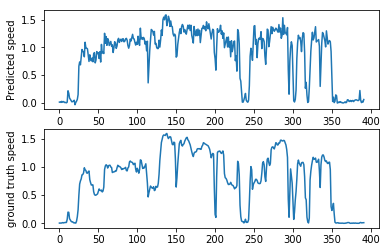

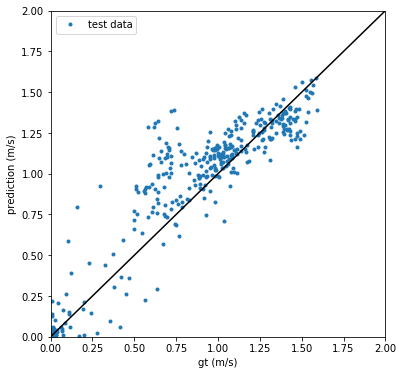

In [20]:
# Evaluate in unknown data to the network.
nfolders=[]
nfolders.append("/static/dataset-04/")
Test=OdometryDataset("./../data/",nfolders,transform=ToTensor())
test_Loader = DataLoader(Test, batch_size=1,shuffle=False, num_workers=1)

pred=[]
sp=[]
t=[]
for i_batch, sample_batched in enumerate(test_Loader):
    data=sample_batched
    pred.append(model(Variable(data['imu'].float())).data[0].cpu().numpy())
    vec=data['gt']
    #vertical=torch.norm(vec[:,[1]],2,1) 
    #vertical=vec[:,1]
    #horizontal=torch.norm(vec[:,[0,2]],2,1)  
    #y=torch.stack((vertical,horizontal),1)
    y=torch.norm(data['gt'],2,1).type(torch.FloatTensor)
    sp.append(y.type(torch.FloatTensor).numpy())
    t.append(data['time'])
plt.subplot(211)
plt.plot(np.asarray(pred))
plt.ylabel('Predicted speed')
plt.subplot(212)
plt.plot(np.asarray(sp)[:,0])
plt.ylabel('ground truth speed')
plt.show()
fig = plt.figure(figsize=(6,6))
plt.plot(np.asarray(sp)[:,0],np.asarray(pred)[:],'.', label='test data')
plt.plot([0,2],[0,2],'k')
plt.xlabel('gt (m/s)')
plt.ylabel('prediction (m/s)')

axes=plt.gca()

axes.set_xlim((0.0,2))
axes.set_ylim([0.0,2])
axes.legend()
plt.show()

In [19]:
ls ../data


dataset-04/
